# Часть 1. Vanilla Autoencoder (10 баллов)

## 1.1. Подготовка данных (0.5 балла)


In [1]:
import numpy as np
from torch.autograd import Variable
from torchvision import datasets
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data_utils
import torch
import matplotlib.pyplot as plt

import os
import pandas as pd
import skimage.io
from skimage.transform import resize


%matplotlib inline

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
def fetch_dataset(attrs_name = "lfw_attributes.txt",
                      images_name = "lfw-deepfunneled",
                      dx=80,dy=80,
                      dimx=64,dimy=64
    ):

    #download if not exists
    if not os.path.exists(images_name):
        print("images not found, donwloading...")
        os.system("wget http://vis-www.cs.umass.edu/lfw/lfw-deepfunneled.tgz -O tmp.tgz")
        print("extracting...")
        os.system("tar xvzf tmp.tgz && rm tmp.tgz")
        print("done")
        assert os.path.exists(images_name)

    if not os.path.exists(attrs_name):
        print("attributes not found, downloading...")
        os.system("wget http://www.cs.columbia.edu/CAVE/databases/pubfig/download/%s" % attrs_name)
        print("done")

    #read attrs
    df_attrs = pd.read_csv("lfw_attributes.txt",sep='\t',skiprows=1,) 
    df_attrs = pd.DataFrame(df_attrs.iloc[:,:-1].values, columns = df_attrs.columns[1:])


    #read photos
    photo_ids = []
    for dirpath, dirnames, filenames in os.walk(images_name):
        for fname in filenames:
            if fname.endswith(".jpg"):
                fpath = os.path.join(dirpath,fname)
                photo_id = fname[:-4].replace('_',' ').split()
                person_id = ' '.join(photo_id[:-1])
                photo_number = int(photo_id[-1])
                photo_ids.append({'person':person_id,'imagenum':photo_number,'photo_path':fpath})

    photo_ids = pd.DataFrame(photo_ids)
    # print(photo_ids)
    #mass-merge
    #(photos now have same order as attributes)
    df = pd.merge(df_attrs,photo_ids,on=('person','imagenum'))

    assert len(df)==len(df_attrs),"lost some data when merging dataframes"

    # print(df.shape)
    #image preprocessing
    all_photos =df['photo_path'].apply(skimage.io.imread)\
                                .apply(lambda img:img[dy:-dy,dx:-dx])\
                                .apply(lambda img: resize(img,[dimx,dimy]))

    all_photos = np.stack(all_photos.values)#.astype('uint8')
    all_attrs = df.drop(["photo_path","person","imagenum"],axis=1)
    
    return all_photos, all_attrs

In [4]:
# The following line fetches you two datasets: images, usable for autoencoder training and attributes.
# Those attributes will be required for the final part of the assignment (applying smiles), so please keep them in mind
data, attrs = fetch_dataset()
from IPython.display import clear_output
clear_output(True)


Разбейте выборку картинок на train и val, выведите несколько картинок в output, чтобы посмотреть, как они выглядят, и приведите картинки к тензорам pytorch, чтобы можно было скормить их сети:

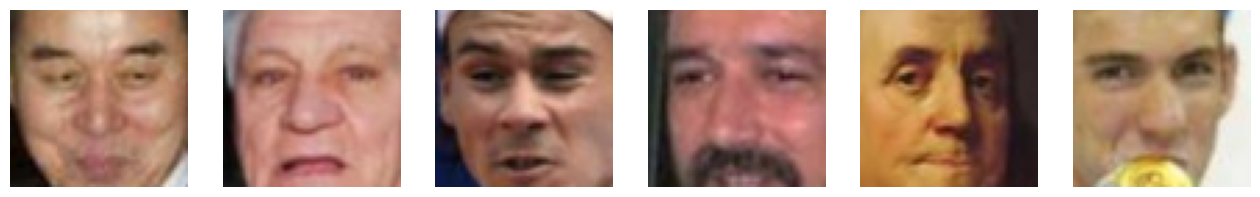

In [5]:
#Рассмотрим несколько случайных изображений
plt.figure(figsize=(16, 9))
samples = np.random.randint(1, data.shape[0], 6)
for i, s in enumerate(samples):
    plt.subplot(1, 6, i+1)
    plt.axis("off")
    plt.imshow(data[s])    
plt.show();

In [6]:
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader
#Преобразуем массив к виду более удобному для pytorch
data_tr = np.transpose(data, [0, 3, 2, 1])
#Разобъем выборку на train и val; атрибуты представим в качестве y, для сохранения соответствия строк данных и атрибутов
X_train, X_val, y_train, y_val = train_test_split(data_tr, attrs, test_size=0.2, random_state=42, shuffle = True)
X_train = torch.FloatTensor(X_train)
X_val = torch.FloatTensor(X_val)

#sklearn уже перемешал картинки, отклчим shuffle в DataLoader
trainloader  = DataLoader(X_train, batch_size = 64, shuffle=False )
valloader = DataLoader(X_val, batch_size = 64, shuffle=False )

## 1.2. Архитектура модели (1.5 балла)
В этом разделе мы напишем и обучем обычный автоэнкодер.



<img src="https://www.notion.so/image/https%3A%2F%2Fs3-us-west-2.amazonaws.com%2Fsecure.notion-static.com%2F4b8adf79-8e6a-4b7d-9061-8617a00edbb1%2F__2021-04-30__14.53.33.png?table=block&id=56f187b4-279f-4208-b1ed-4bda5f91bfc0&width=2880&userId=3b1b5e32-1cfb-4b0f-8705-5a524a8f56e3&cache=v2" alt="Autoencoder">


^ напомню, что автоэнкодер выглядит вот так

In [7]:
dim_code = 75 # выберите размер латентного вектора

Реализуем autoencoder. Архитектуру (conv, fully-connected, ReLu, etc) можете выбирать сами. Экспериментируйте!

In [8]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
        nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1), #3x64x64 -> 16x64x64
        nn.BatchNorm2d(16),
        nn.LeakyReLU(),
        nn.Conv2d(16, 16, kernel_size=3, stride=2, padding=1), #16x64x64 -> 16x32x32
        nn.BatchNorm2d(16),
        nn.LeakyReLU(),
        nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1), #16x32x32 -> 32x16x16
        nn.BatchNorm2d(32),
        nn.LeakyReLU(),
        nn.Conv2d(32, 32, kernel_size=3, stride=2, padding=1), #32x16x16 -> 32x8x8
        nn.BatchNorm2d(32),
        nn.LeakyReLU(),
        nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),#32x8x8 -> 64x8x8
        nn.BatchNorm2d(64),
        nn.LeakyReLU(),
        nn.Flatten(),
        nn.Linear(4096, dim_code)
    )
        self.decoder = nn.Sequential(
        nn.Linear(dim_code, 4096),
        nn.Unflatten(1, (64, 8, 8)),
        nn.ConvTranspose2d(64, 32, kernel_size=3, stride=1, padding=1), #64x8x8 -> 32x8x8 
        nn.BatchNorm2d(32),   
        nn.LeakyReLU(),
        nn.ConvTranspose2d(32, 32, kernel_size=3, stride=2, padding=1, output_padding=1), #32x8x8 -> 32x16x16
        nn.BatchNorm2d(32),   
        nn.LeakyReLU(),
        nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1, output_padding=1), #32x16x16 -> 16x32x32
        nn.BatchNorm2d(16), 
        nn.LeakyReLU(),  
        nn.ConvTranspose2d(16, 16, kernel_size=3, stride=2, padding=1, output_padding=1), #16x32x32 -> 16x64x64
        nn.BatchNorm2d(16), 
        nn.LeakyReLU(),
        nn.ConvTranspose2d(16, 3, kernel_size=3, stride=1, padding=1),#16x64x64 -> 3x64x64
    )
        
    def forward(self, x):
        latent_code = self.encoder(x)
        reconstruction = self.decoder(latent_code)
        return reconstruction, latent_code
    
    def enc_pred(self, x):
        x = self.encoder(x).detach()
        return x
        
    def dec_pred(self, x):
        x = self.decoder(x).detach()
        return x

In [9]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

criterion = nn.MSELoss()
autoencoder = Autoencoder().to(device)
optimizer = optim.AdamW(autoencoder.parameters(), lr=0.05, weight_decay=0.05)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer,milestones = [ 20, 30, 40],  gamma=0.3)

## 1.3 Обучение (2 балла)

Осталось написать код обучения автоэнкодера. При этом было бы неплохо в процессе иногда смотреть, как автоэнкодер реконструирует изображения на данном этапе обучения. Наример, после каждой эпохи (прогона train выборки через автоэекодер) можно смотреть, какие реконструкции получились для каких-то изображений val выборки.

А, ну еще было бы неплохо выводить графики train и val лоссов в процессе тренировки =)

In [10]:
def plot_epoch(t_loss, v_loss, epoch, val_data):
    plt.style.use('bmh')
    fig, axs = plt.subplots(ncols=3, nrows=2, figsize = (16,9))
    gs = axs[1, 2].get_gridspec()
    for ax in axs[0, 0:]:
        ax.remove()
    axbig = fig.add_subplot(gs[0, 0:])
    fig.subplots_adjust(wspace=0)
    for ax in axs[1, 0:]:
        ax.axis('off') 
    axbig.plot( np.arange(1, epoch+1, 1),t_loss, label='train')
    axbig.plot( np.arange(1, epoch+1, 1), v_loss, label='val')
    plt.legend()
    for nimage in range(3):
        axs[1,nimage].imshow(val_data[nimage])
    plt.show()

epoch: 50 loss train: 0.0028 loss val: 0.0030


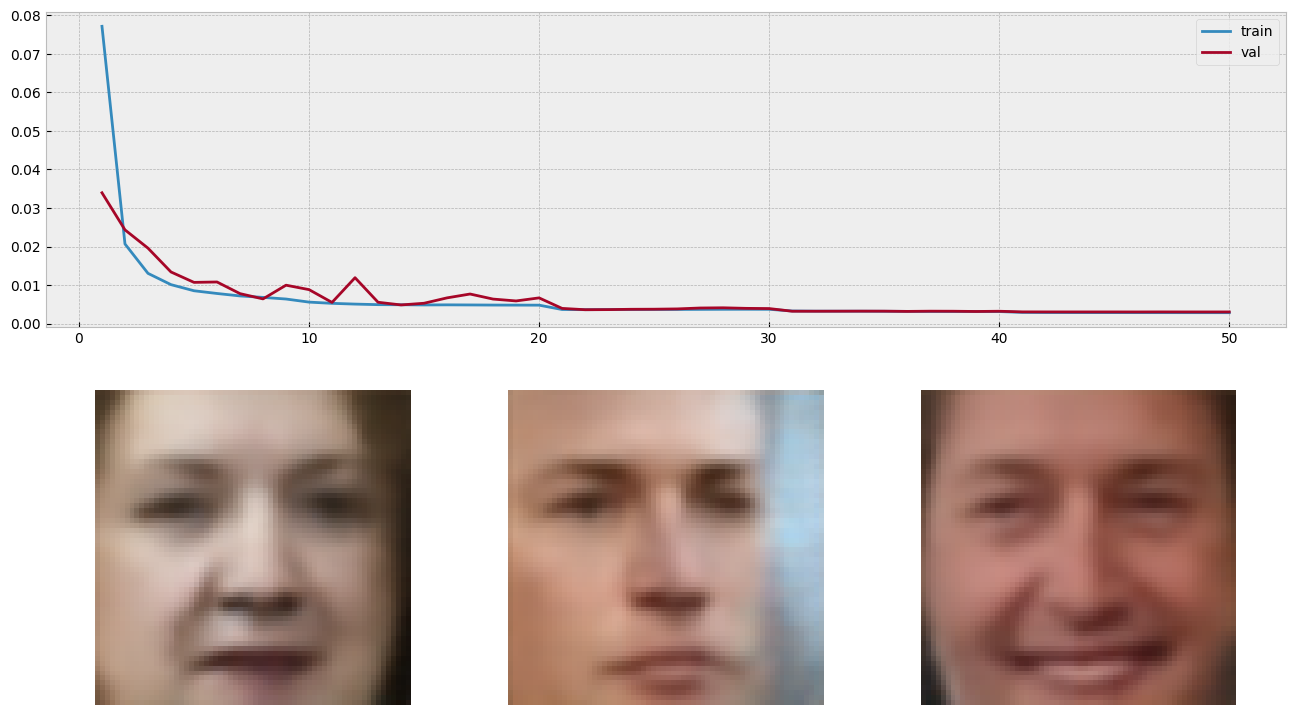

In [11]:
from IPython.display import clear_output
n_epochs = 50
train_losses = []
val_losses = []

for epoch in range(1, n_epochs + 1):
    autoencoder.train()
    train_losses_per_epoch = []
    for batch in trainloader:
        optimizer.zero_grad()
        output, _ = autoencoder.forward(batch.to(device))
        loss = criterion(output, batch.to(device))
        loss.backward()
        optimizer.step()
        train_losses_per_epoch.append(loss.item())

    train_losses.append(np.mean(train_losses_per_epoch))

    autoencoder.eval()
    val_losses_per_epoch = []
    with torch.no_grad():
        for batch in valloader:
          output, _ = autoencoder.forward(batch.to(device))
          loss = criterion(output, batch.to(device))
          val_losses_per_epoch.append(loss.item())
        
    val_losses.append(np.mean(val_losses_per_epoch))
    scheduler.step()
    
    clear_output(True)
    
    print(f'epoch: {epoch} loss train: {np.mean(train_losses_per_epoch):.4f} loss val: {np.mean(val_losses_per_epoch):.4f}')
    val_data = torch.transpose(output.to('cpu'), 1, 3)
    val_data[val_data<0] = 0
    plot_epoch(train_losses, val_losses, epoch, val_data)

In [12]:
def val_images(model):
    val_true = torch.transpose(next(iter(valloader)), 1, 3)
    val_pred = torch.transpose(model.forward(next(iter(valloader)).to(device))[0].to('cpu').detach(), 1, 3)
    val_pred[val_pred < 0] = 0
    val_pred[val_pred > 1] = 1
    plt.figure(figsize=(18, 6))
    for i in range(6):
        plt.subplot(2, 6, i+1)
        plt.axis("off")
        plt.title('true_image')
        plt.imshow(val_true[i])

        plt.subplot(2, 6, i+7)
        plt.axis("off")
        plt.title('predicted_image')
        plt.imshow(val_pred[i])
    plt.show();

Давайте посмотрим, как наш тренированный автоэекодер кодирует и восстанавливает картинки:

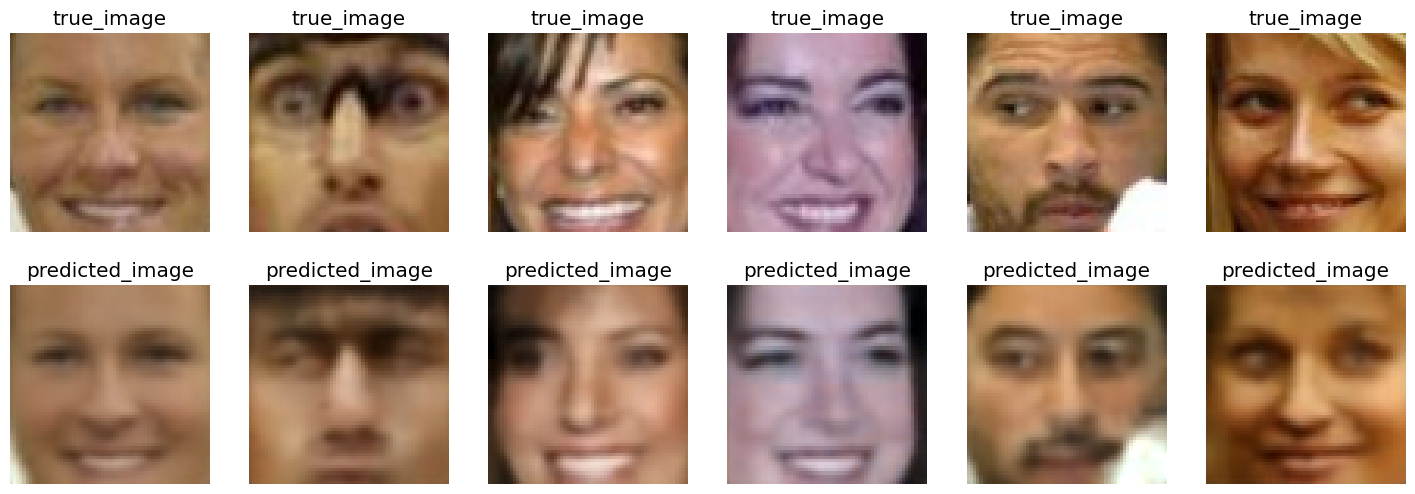

In [13]:
#Выведем несколько изображений валидационной выборки и ихвосстановленные копии
val_images(autoencoder)

Not bad, right? 

## 1.4. Sampling (2 балла)

Давайте теперь будем не просто брать картинку, прогонять ее через автоэекодер и получать реконструкцию, а попробуем создать что-то НОВОЕ

Давайте возьмем и подсунем декодеру какие-нибудь сгенерированные нами векторы (например, из нормального распределения) и посмотрим на результат реконструкции декодера:

__Подсказка:__Е сли вместо лиц у вас выводится непонятно что, попробуйте посмотреть, как выглядят латентные векторы картинок из датасета. Так как в обучении нейронных сетей есть определенная доля рандома, векторы латентного слоя могут быть распределены НЕ как `np.random.randn(25, <latent_space_dim>)`. А чтобы у нас получались лица при запихивании вектора декодеру, вектор должен быть распределен так же, как латентные векторы реальных фоток. Так что в таком случае придется рандом немного подогнать.

In [14]:
#Создадим массивы латентных координат
coords = np.ones((1,dim_code))
with torch.no_grad():
        for batch in trainloader:
            coord = autoencoder.enc_pred(batch.to(device)).to('cpu')
            coords = np.vstack((coords, coord.numpy()))
coords = coords[1:]

In [15]:
#Найдем среднее и стандартное отклонение для каждой координаты латентного вектора
mus = coords.mean(axis=0)
sigmas = coords.std(axis=0)

In [17]:
#Найдем случайные числа для координат латентного вектора, используя dim_code распределений (для каждой координаты вектора своё распределение)
sampleCoords = np.ones([25, 1])
for e, s in zip(mus, sigmas):
    randRows = np.random.normal(e, s,(25, 1))
    sampleCoords = np.hstack([sampleCoords, randRows])
sampleCoords =  torch.FloatTensor(sampleCoords[:, 1:])

In [18]:
sampleImages = torch.transpose(autoencoder.dec_pred(sampleCoords.to(device)), 1, 3).to('cpu')
sampleImages[sampleImages<0] = 0
sampleImages[sampleImages>1] = 1

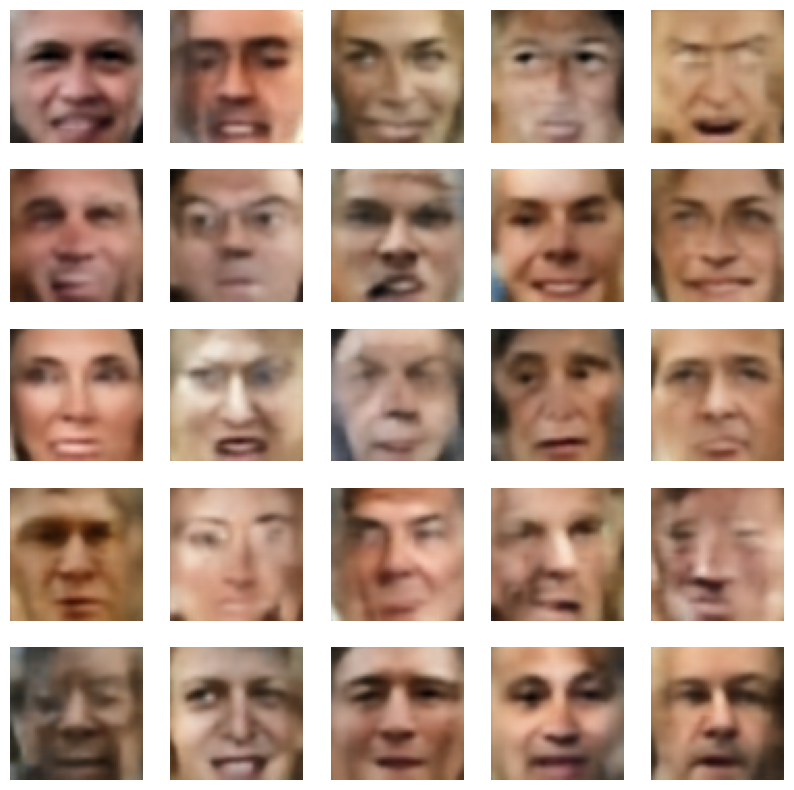

In [20]:
#И вот 25 новых уродливых лиц
plt.figure(figsize=(10, 10))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.axis("off")
    plt.imshow(sampleImages[i])
plt.show();

## 1.5 Time to make fun! (4 балла)

Давайте научимся пририсовывать людям улыбки =)

План такой:

1. Нужно выделить "вектор улыбки": для этого нужно из выборки изображений найти несколько (~15) людей с улыбками и столько же без.

Найти людей с улыбками вам поможет файл с описанием датасета, скачанный вместе с датасетом. В нем указаны имена картинок и присутствубщие атрибуты (улыбки, очки...)

2. Вычислить латентный вектор для всех улыбающихся людей (прогнать их через encoder) и то же для всех грустненьких

3. Вычислить, собственно, вектор улыбки -- посчитать разность между средним латентным вектором улыбающихся людей и средним латентным вектором грустных людей

4. А теперь приделаем улыбку грустному человеку: добавим полученный в пункте 3 вектор к латентному вектору грустного человека и прогоним полученный вектор через decoder. Получим того же человека, но уже не грустненького!

In [21]:
#выделим индексы таблицы pandas, столбца Smilingс выраженными отрицательными значениями (печальные люди)
sadIndex = y_val['Smiling'][y_val['Smiling'] < -1].index

In [22]:
#выделим индексы таблицы pandas, столбца Smilingс выраженными положительными значениями (улыбающиеся люди)
smileIndex = y_val['Smiling'][y_val['Smiling'] > 1].index

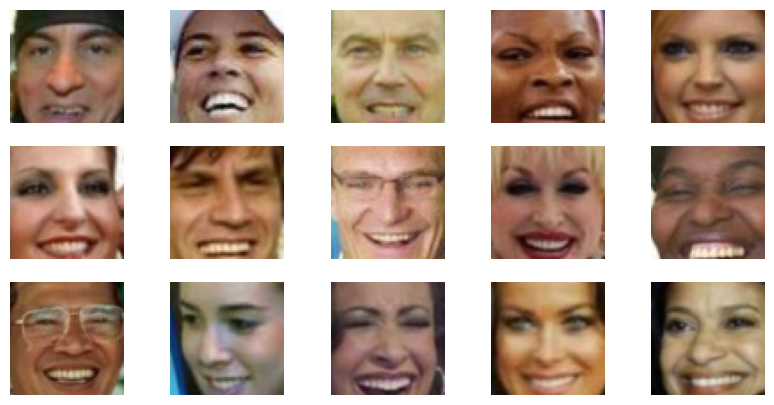

In [23]:
#выберем 15 с улыбкой
plt.figure(figsize=(10, 5))
for i, index in enumerate(smileIndex[15:30]):
    plt.subplot(3, 5, i+1)
    plt.axis("off")
    plt.imshow(data[index])
plt.show();

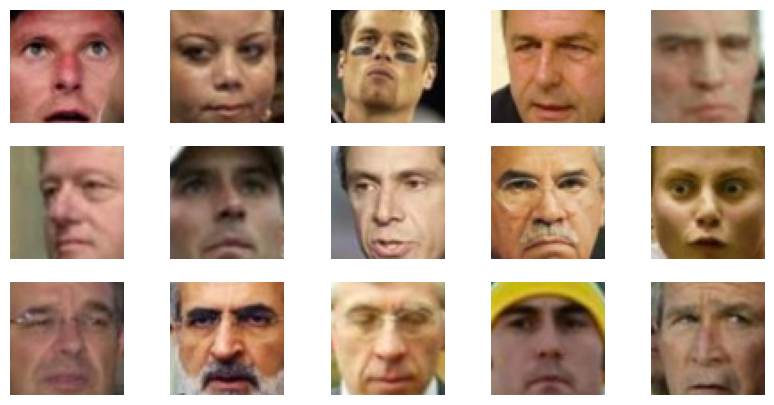

In [24]:
#И 15 без улыбки
plt.figure(figsize=(10, 5))
for i, index in enumerate(sadIndex[30:45]):
    plt.subplot(3, 5, i+1)
    plt.axis("off")
    plt.imshow(data[index])
plt.show();

In [25]:
#Выделим вектор улыбки, как описано в задании
smileFaces = torch.FloatTensor(data[smileIndex[15:30]])
smileFaces = torch.transpose(smileFaces, 1, 3)

sadFaces = torch.FloatTensor(data[sadIndex[30:45]])
sadFaces = torch.transpose(sadFaces, 1, 3)
''
smileCoords = autoencoder.enc_pred(smileFaces.to(device)).mean(dim=0).to('cpu')
sadCoords = autoencoder.enc_pred(sadFaces.to(device)).mean(dim=0).to('cpu')
smile = smileCoords - sadCoords

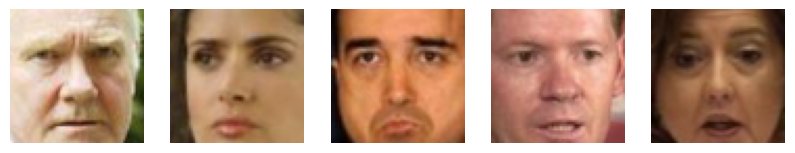

In [26]:
#Выделим 5 человек без улыбки для теста
plt.figure(figsize=(10, 5))
for i, index in enumerate(sadIndex[46:51]):
    plt.subplot(1, 5, i+1)
    plt.axis("off")
    plt.imshow(data[index])
plt.show();

In [27]:
#Добавим в латентном представлении вектор улыбки
sadSamples = torch.FloatTensor(data[sadIndex[46:51]])
sadSamples = torch.transpose(sadSamples, 1, 3)
sadSamplesCoord = autoencoder.enc_pred(sadSamples.to(device)).to('cpu')
sadSamplesSmilesCoord = sadSamplesCoord + smile
sadSamplesSmilesImages = autoencoder.dec_pred(sadSamplesSmilesCoord.to(device)).to('cpu')
sadSamplesSmilesImages = torch.transpose(sadSamplesSmilesImages, 1, 3)
sadSamplesSmilesImages[sadSamplesSmilesImages<0] = 0
sadSamplesSmilesImages[sadSamplesSmilesImages>1] = 1

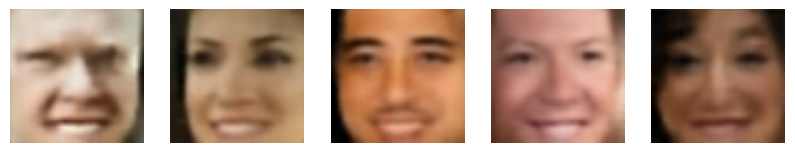

In [28]:
#И вот они уже улыбаются
plt.figure(figsize=(10, 5))
for i in range(5):
    plt.subplot(1, 5, i+1)
    plt.axis("off")
    plt.imshow(sadSamplesSmilesImages[i])
plt.show();

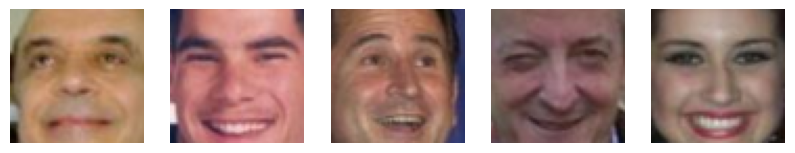

In [29]:
#Аналогичные действия, только наоборот, люди с улыбкой
plt.figure(figsize=(10, 5))
for i, index in enumerate(smileIndex[39:44]):
    plt.subplot(1, 5, i+1)
    plt.axis("off")
    plt.imshow(data[index])
plt.show();

In [30]:
smileSamples = torch.FloatTensor(data[smileIndex[39:44]])
smileSamples = torch.transpose(smileSamples, 1, 3)
smileSamplesCoord = autoencoder.enc_pred(smileSamples.to(device)).to('cpu')
smileSamplesSadCoord = smileSamplesCoord - smile
smileSamplesSadImages = autoencoder.dec_pred(smileSamplesSadCoord.to(device)).to('cpu')
smileSamplesSadImages = torch.transpose(smileSamplesSadImages, 1, 3)
smileSamplesSadImages[smileSamplesSadImages<0] = 0
smileSamplesSadImages[smileSamplesSadImages>1] = 1

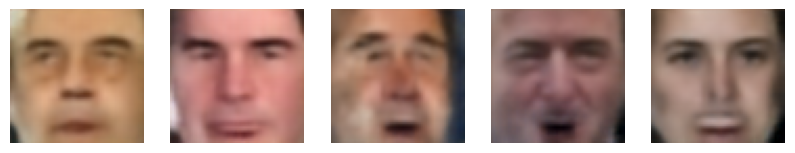

In [31]:
#И вот они уже без улыбки
plt.figure(figsize=(10, 5))
for i in range(5):
    plt.subplot(1, 5, i+1)
    plt.axis("off")
    plt.imshow(smileSamplesSadImages[i])
plt.show();

Вуаля! Вы восхитительны!

Теперь вы можете пририсовывать людям не только улыбки, но и много чего другого -- закрывать/открывать глаза, пририсовывать очки... в общем, все, на что хватит фантазии и на что есть атрибуты в `all_attrs`:)

# Часть 2: Variational Autoencoder (10 баллов) 

Займемся обучением вариационных автоэнкодеров — проапгрейженной версии AE. Обучать будем на датасете MNIST, содержащем написанные от руки цифры от 0 до 9

In [32]:
batch_size = 32
from torchvision import transforms
# MNIST Dataset
train_dataset = datasets.MNIST(root='./mnist_data/', train=True, transform=transforms.ToTensor(), download=True)
test_dataset = datasets.MNIST(root='./mnist_data/', train=False, transform=transforms.ToTensor(), download=False)
# Data Loader (Input Pipeline)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

100%|██████████| 9912422/9912422 [00:00<00:00, 97367005.26it/s]


Extracting ./mnist_data/MNIST/raw/train-images-idx3-ubyte.gz to ./mnist_data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 66925797.69it/s]


Extracting ./mnist_data/MNIST/raw/train-labels-idx1-ubyte.gz to ./mnist_data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 25890384.91it/s]


Extracting ./mnist_data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./mnist_data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 6670353.21it/s]

Extracting ./mnist_data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./mnist_data/MNIST/raw



## 2.1 Архитектура модели и обучение (2 балла)

Реализуем VAE. Архитектуру (conv, fully-connected, ReLu, etc) можете выбирать сами. Рекомендуем пользоваться более сложными моделями, чем та, что была на семинаре:) Экспериментируйте!

In [33]:
features = 16
class VAE(nn.Module):
    
    def __init__(self):
        '''определите архитектуры encoder и decoder
        помните, у encoder должны быть два "хвоста", 
        т.е. encoder должен кодировать картинку в 2 переменные -- mu и logsigma'''
        super(VAE, self).__init__()
        self.encoder = nn.Sequential(
        nn.Conv2d(1, 8, kernel_size=3, stride=1, padding=1), #1x28x28 -> 8x28x28
        nn.BatchNorm2d(8),
        nn.LeakyReLU(),
        nn.Conv2d(8, 8, kernel_size=3, stride=2, padding=1), #8x28x28 -> 8x14x14
        nn.BatchNorm2d(8),
        nn.LeakyReLU(),
        nn.Conv2d(8, 16, kernel_size=3, stride=2, padding=1), #8x14x14 -> 16x7x7
        nn.BatchNorm2d(16),
        nn.LeakyReLU(),
        nn.Conv2d(16, 16, kernel_size=3, stride=1, padding=1),#16x7x7 -> 16x7x7
        nn.BatchNorm2d(16),
        nn.LeakyReLU(),
        nn.Flatten(),
        nn.Linear(784, features * 2)
        )
        self.decoder = nn.Sequential(
        nn.Linear(features, 784),
        nn.Unflatten(1, (16, 7, 7)),
        nn.ConvTranspose2d(16, 16, kernel_size=3, stride=1, padding=1), #16x7x7 -> 16x7x7 
        nn.BatchNorm2d(16),   
        nn.LeakyReLU(),
        nn.ConvTranspose2d(16, 8, kernel_size=3, stride=2, padding=1, output_padding=1), #16x7x7 -> 8x14x14
        nn.BatchNorm2d(8), 
        nn.LeakyReLU(),  
        nn.ConvTranspose2d(8, 8, kernel_size=3, stride=2, padding=1, output_padding=1), #8x14x14 -> 8x28x28
        nn.BatchNorm2d(8), 
        nn.LeakyReLU(),
        nn.ConvTranspose2d(8, 1, kernel_size=3, stride=1, padding=1),#8x28x28 -> 1x28x28
    )
        

    def encode(self, x):
        #<реализуйте forward проход энкодерав качестве ваозвращаемых переменных -- mu и logsigma>
        x = self.encoder(x).view(-1, 2, features)
        mu = x[:, 0, :] # the first feature values as mean
        logsigma = x[:, 1, :] # the other feature values as sigma
        return mu, logsigma
    
    def gaussian_sampler(self, mu, logsigma):
        #засемплируйте латентный вектор из нормального распределения с параметрами mu и sigma>
        #Под logsigma подразумевается логарифм квадрата СКО (логарифм дисперсии)
        if self.training:
            std = torch.exp(0.5*logsigma) # standard deviation
            eps = torch.randn_like(std) # `randn_like` as we need the same size
            sample = mu + (eps * std) # sampling as if coming from the input space
            return sample
        else:
            # на инференсе возвращаем не случайный вектор из нормального распределения, а центральный -- mu. 
            # на инференсе выход автоэнкодера должен быть детерминирован.
            return mu
    
    def decode(self, z):
        #<реализуйте forward проход декодера в качестве возвращаемой переменной -- reconstruction>
        reconstruction = self.decoder(z)
        
        return reconstruction

    def forward(self, x):
        '''<используя encode и decode, реализуйте forward проход автоэнкодера
        в качестве ваозвращаемых переменных -- mu, logsigma и reconstruction>'''
        mu, logsigma = self.encode(x)
        z = self.gaussian_sampler(mu, logsigma)
        reconstruction = self.decode(z)
        return mu, logsigma, reconstruction

Определим лосс и его компоненты для VAE:

Надеюсь, вы уже прочитали материал в towardsdatascience (или еще где-то) про VAE и знаете, что лосс у VAE состоит из двух частей: KL и log-likelihood.

Общий лосс будет выглядеть так:

$$\mathcal{L} = -D_{KL}(q_{\phi}(z|x)||p(z)) + \log p_{\theta}(x|z)$$

Формула для KL-дивергенции:

$$D_{KL} = -\frac{1}{2}\sum_{i=1}^{dimZ}(1+log(\sigma_i^2)-\mu_i^2-\sigma_i^2)$$

В качестве log-likelihood возьмем привычную нам кросс-энтропию.

In [34]:
#logsigma считаем логарифмом квадрата СКО, т.е. дисперсией
def KL_divergence(mu, logsigma):
    """
    часть функции потерь, которая отвечает за "близость" латентных представлений разных людей
    """
    loss = -0.5 * torch.sum(1 + logsigma - mu.pow(2) - logsigma.exp())
    return loss

def log_likelihood(x, reconstruction):
    """
    часть функции потерь, которая отвечает за качество реконструкции (как mse в обычном autoencoder)
    """
    loss = nn.BCEWithLogitsLoss(reduction = 'sum')
    return loss(reconstruction, x)

def loss_vae(x, mu, logsigma, reconstruction):
    return KL_divergence(mu, logsigma) + log_likelihood(x, reconstruction)

И обучим модель:

In [35]:
criterion = loss_vae

autoencoder = VAE().to(device)

optimizer = optim.AdamW(autoencoder.parameters(), lr=0.001, weight_decay=0.05)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer,milestones = [ 20 ],  gamma=0.1)

epoch: 30 loss train: 3221.0817 loss val: 2963.5113


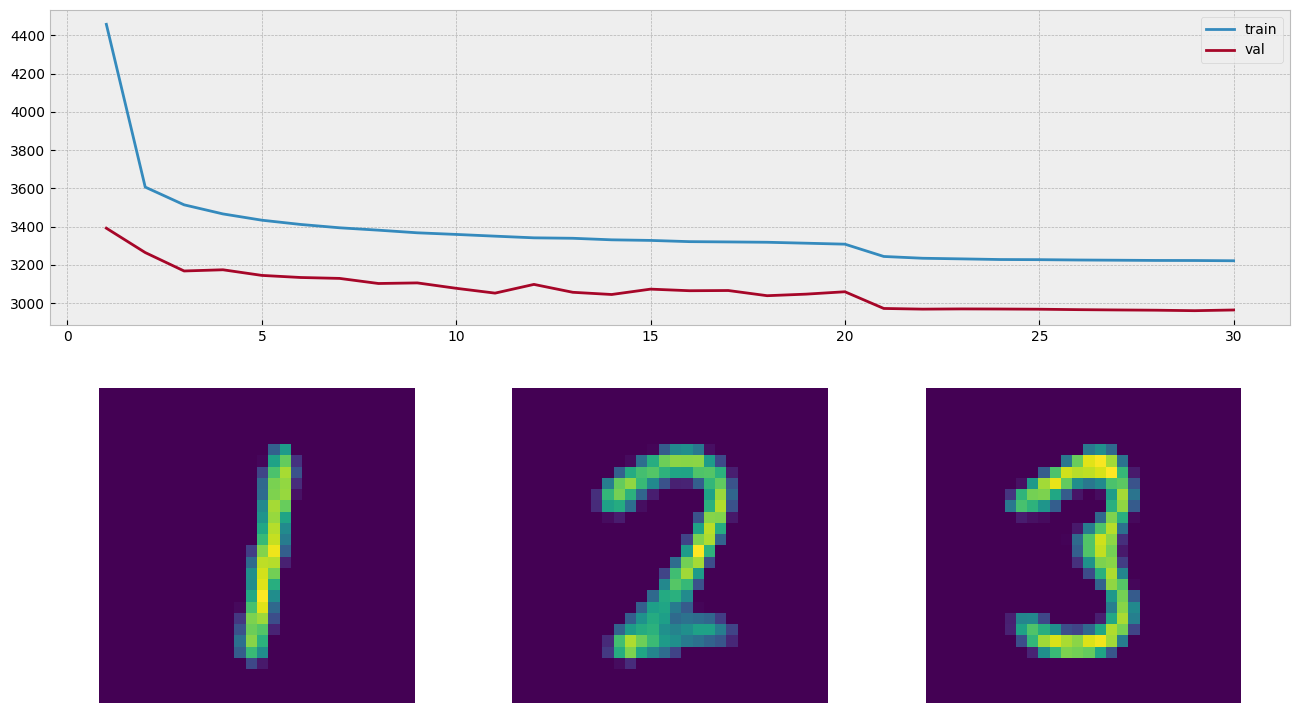

In [36]:
from IPython.display import clear_output
n_epochs = 30
train_losses = []
val_losses = []

for epoch in range(1, n_epochs + 1):
    autoencoder.train()
    train_losses_per_epoch = []
    for batch, _ in train_loader:
        optimizer.zero_grad()
        mu, logsigma, reconstruction = autoencoder.forward(batch.to(device))
        loss = criterion(batch.to(device), mu, logsigma, reconstruction)
        loss.backward()
        optimizer.step()
        train_losses_per_epoch.append(loss.item())

    train_losses.append(np.mean(train_losses_per_epoch))

    autoencoder.eval()
    val_losses_per_epoch = []
    with torch.no_grad():
        for batch, _ in test_loader:
          mu, logsigma, reconstruction = autoencoder.forward(batch.to(device))
          loss = criterion(batch.to(device), mu, logsigma, reconstruction)
          val_losses_per_epoch.append(loss.item())
        
    val_losses.append(np.mean(val_losses_per_epoch))
    scheduler.step()
    
    clear_output(True)
    print(f'epoch: {epoch} loss train: {np.mean(train_losses_per_epoch):.4f} loss val: {np.mean(val_losses_per_epoch):.4f}')
    val_data = reconstruction.to('cpu').view([-1, 28, 28])
    val_data[val_data<0] = 0
    plot_epoch(train_losses, val_losses, epoch, val_data)

Давайте посмотрим, как наш тренированный VAE кодирует и восстанавливает картинки:

In [37]:
def val_images2(model):
    val_true = next(iter(test_loader))[0].view([-1, 28, 28])
    val_pred = autoencoder.forward((next(iter(test_loader))[0].to(device)))[2].view([-1, 28, 28]).detach().to('cpu')
    val_pred[val_pred < 0] = 0
    val_pred[val_pred > 1] = 1
    plt.figure(figsize=(18, 6))
    for i in range(6):
        plt.subplot(2, 6, i+1)
        plt.axis("off")
        plt.title('true_image')
        plt.imshow(val_true[i])

        plt.subplot(2, 6, i+7)
        plt.axis("off")
        plt.title('predicted_image')
        plt.imshow(val_pred[i])
    plt.show();

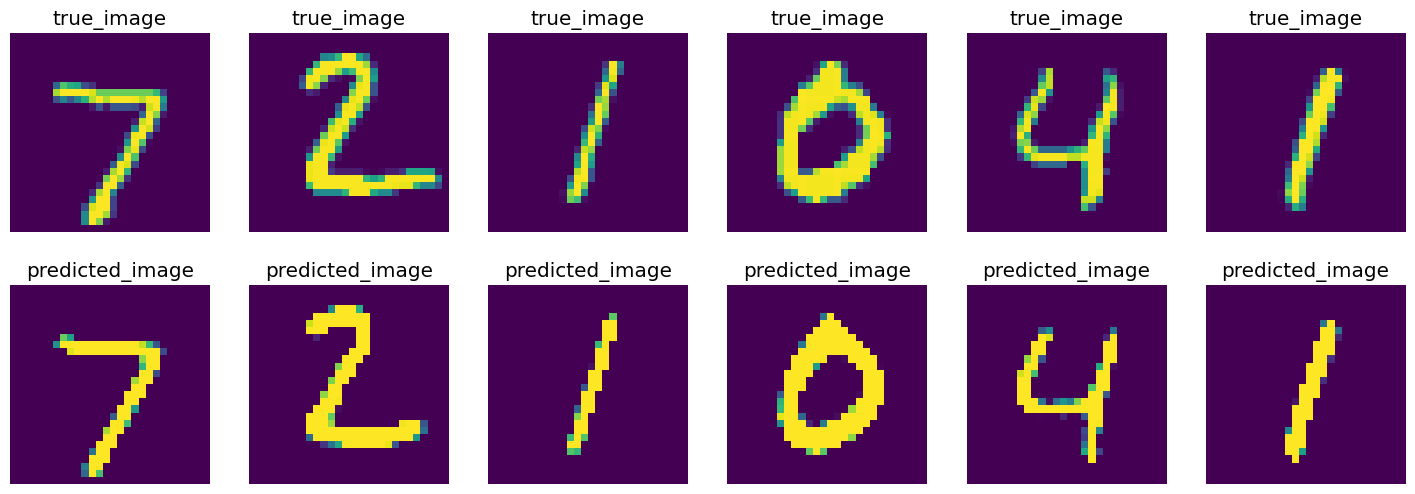

In [38]:
#Выведем изображения цифр и их восстановленные копии
val_images2(autoencoder)

Давайте попробуем проделать для VAE то же, что и с обычным автоэнкодером -- подсунуть decoder'у из VAE случайные векторы из нормального распределения и посмотреть, какие картинки получаются:

In [39]:
#Выведем 10 случайных изображений со случайными латентными координатами
#Т.к. выборка занчительно проще достаточно одного распределения
seed = np.random.seed(7)
z = torch.FloatTensor(np.array([np.random.normal(0, 1, features) for i in range(10)])).to(device)
output = autoencoder.decode(z).detach().to('cpu').view([-1, 28, 28])
output[output < 0] = 0
output[output > 1] = 1

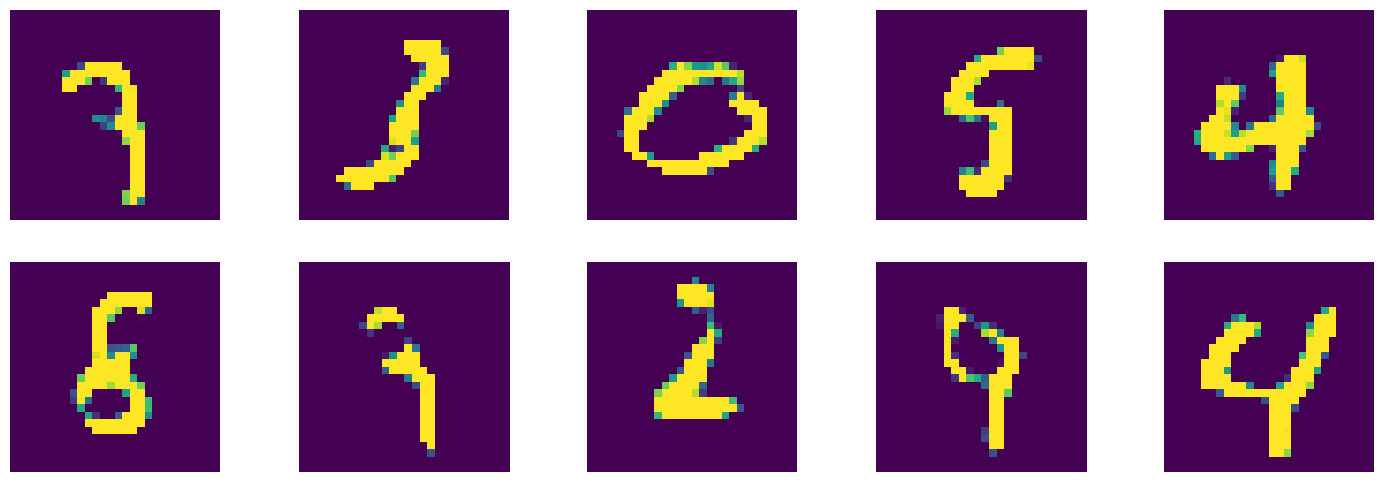

In [40]:
#Вот, новые цифры
plt.figure(figsize=(18, 6))
for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.axis("off")
    plt.imshow(output[i])
plt.show();

## 2.2. Latent Representation (2 балла)

Давайте посмотрим, как латентные векторы картинок цифр выглядят в пространстве.
Ваша задача -- изобразить латентные векторы картинок точками в двумерном просторанстве. 

Это позволит оценить, насколько плотно распределены латентные векторы изображений цифр в пространстве. 

Плюс давайте сделаем такую вещь: покрасим точки, которые соответствуют картинкам каждой цифры, в свой отдельный цвет

Подсказка: красить -- это просто =) У plt.scatter есть параметр c (color), см. в документации.


Итак, план:
1. Получить латентные представления картинок тестового датасета
2. С помощтю `TSNE` (есть в `sklearn`) сжать эти представления до размерности 2 (чтобы можно было их визуализировать точками в пространстве)
3. Визуализировать полученные двумерные представления с помощью `matplotlib.scatter`, покрасить разными цветами точки, соответствующие картинкам разных цифр.

In [41]:
#<ваш код получения латентных представлений, применения TSNE и визуализации>
#Найдем координаты всех цифр тестовой выборки
mnist_coords = np.ones([1, features])
minst_labels = np.ones([1])
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        mu, _ = autoencoder.encode(X_batch.to(device))
        mnist_coords = np.vstack([mnist_coords, mu.to('cpu').numpy()])
        minst_labels =np.concatenate((minst_labels, y_batch.numpy()))
mnist_coords = mnist_coords[1:]
minst_labels = minst_labels[1:]

In [42]:
#Сожмем количество латентных координат до двух
from sklearn.manifold import TSNE
coords_embedded = TSNE(n_components=2, learning_rate='auto', init='random', perplexity=30, random_state=42).fit_transform(mnist_coords)

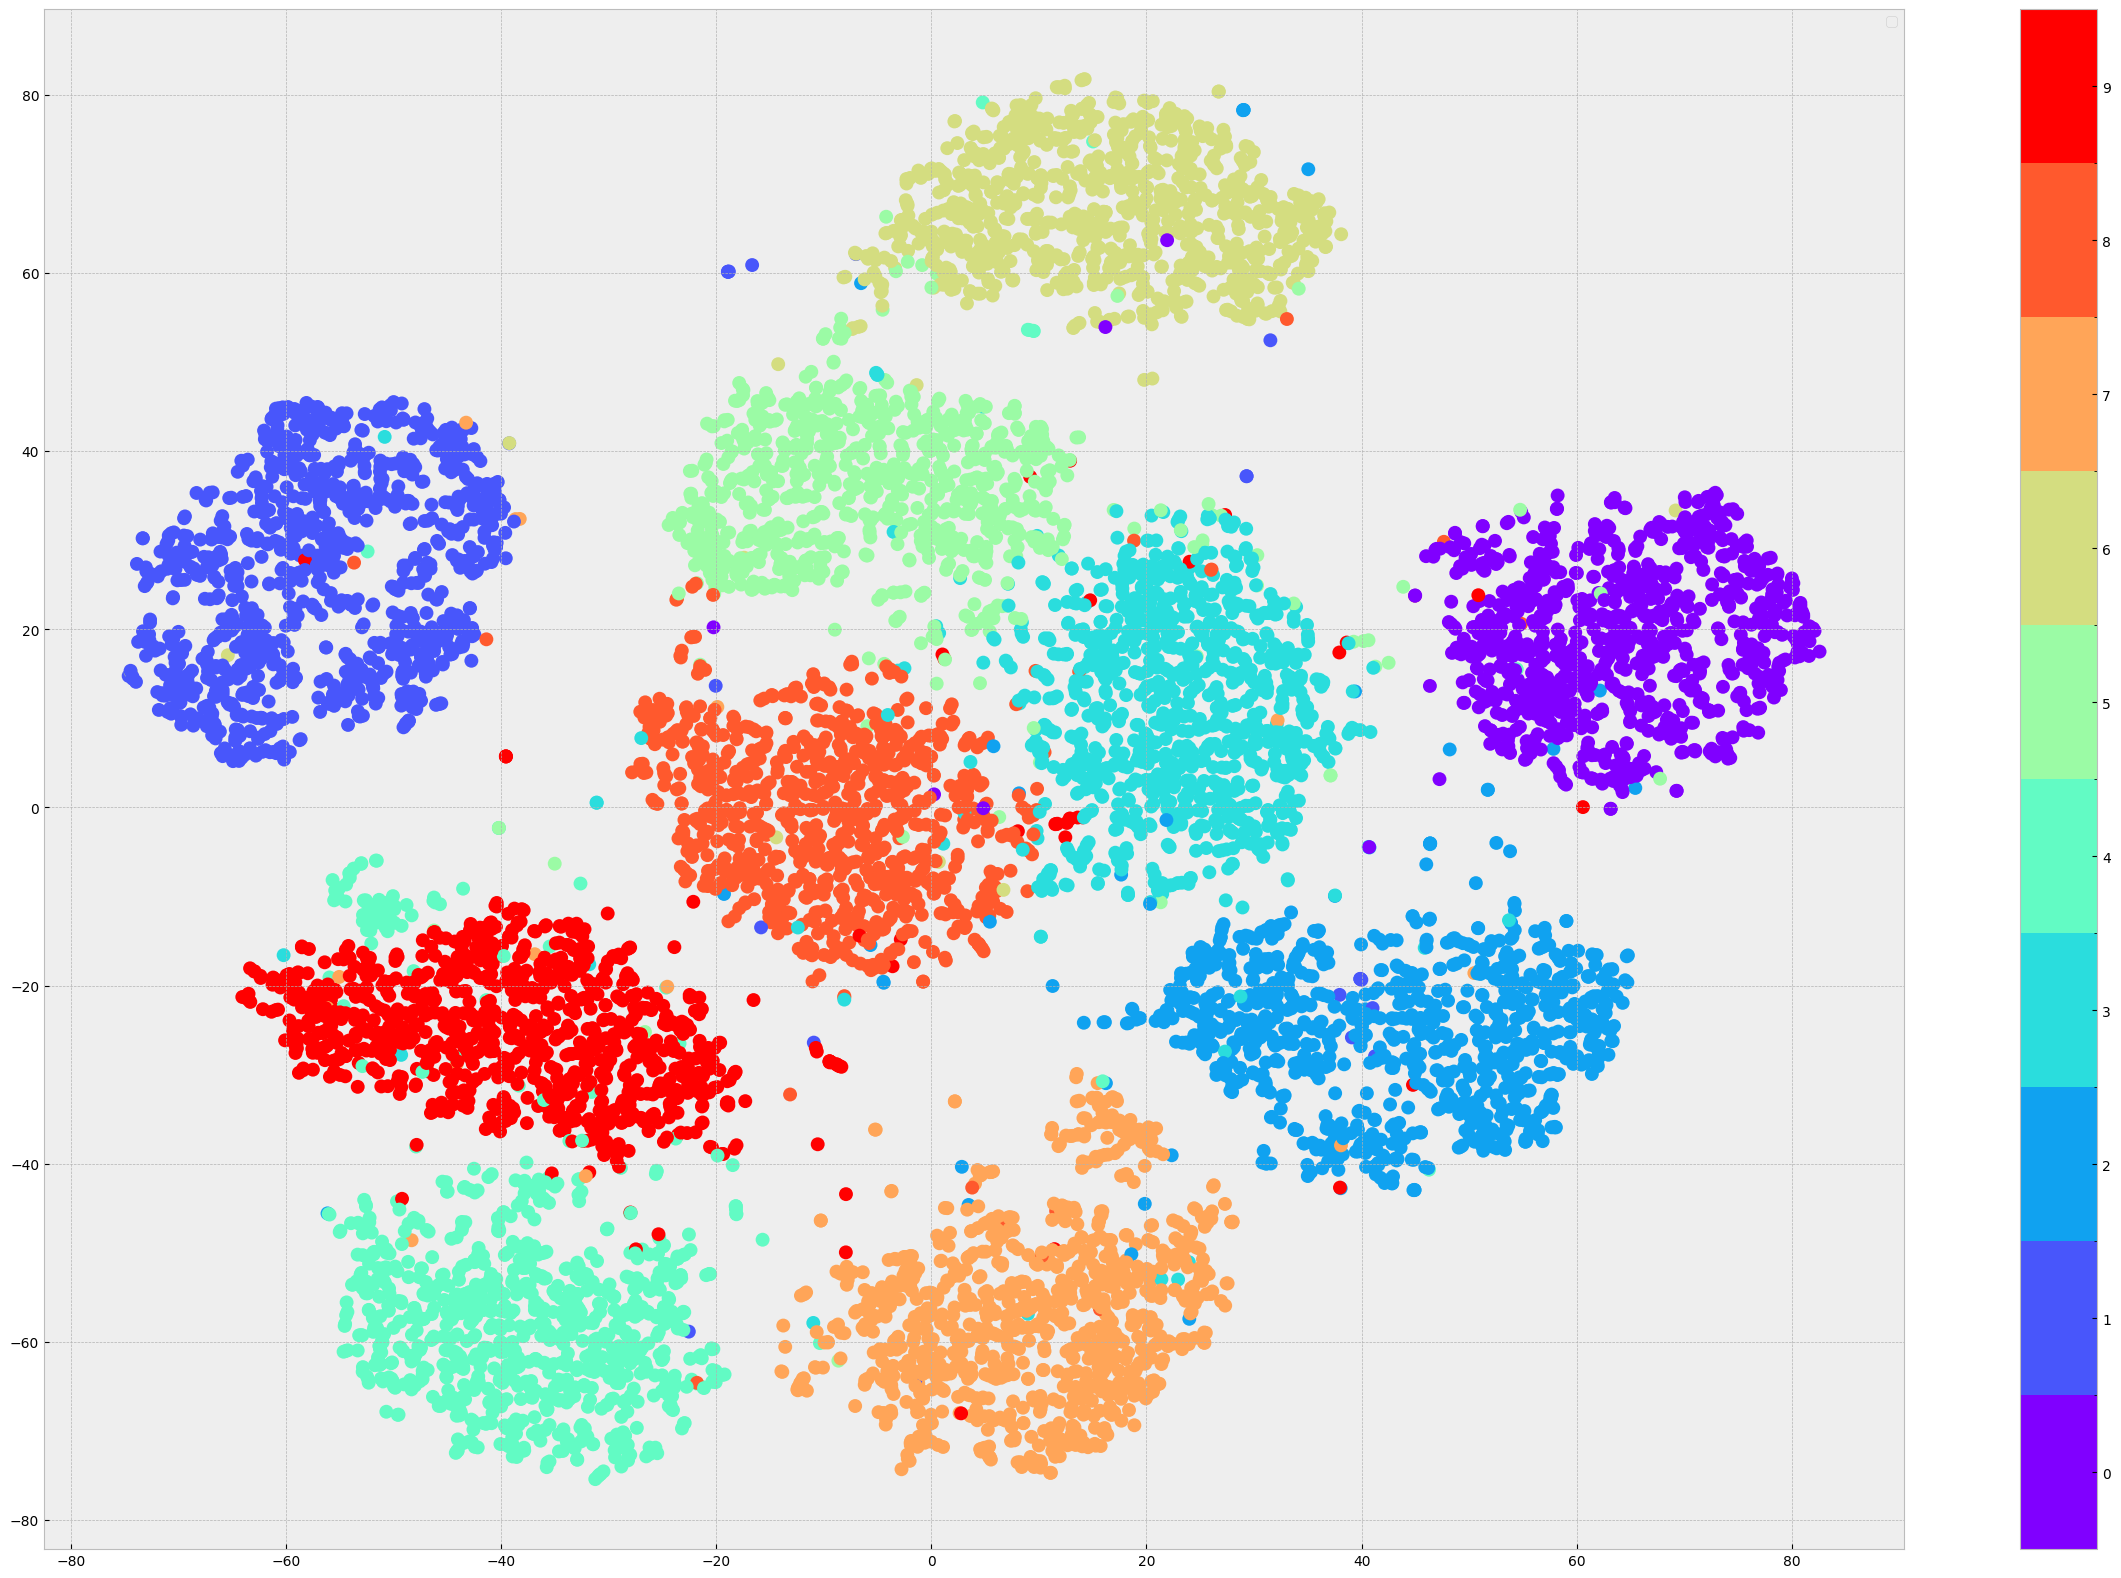

In [43]:
#Выведем распределение латентных координат
from matplotlib import colors
plt.figure(figsize=(30,20))
cmap = plt.cm.rainbow
norm = colors.BoundaryNorm(np.arange(-0.5, 10.5, 1), cmap.N)

plt.scatter(coords_embedded[:, 0], coords_embedded[:, 1], c=minst_labels, cmap=cmap, norm=norm, s=100, edgecolor='none')
plt.colorbar(ticks=np.arange(0, 10, 1))
plt.legend()
plt.show()

Что вы думаете о виде латентного представления?

На изображении представлены округлые агломерации точек, сгруппированные по значению класса. Некоторые агломерации переходят один в другую, характеризуя таким образом непрерывный переход от класа к другому классу.

__Congrats v2.0!__

## 2.3. Conditional VAE (6 баллов)


Мы уже научились обучать обычный AE на датасете картинок и получать новые картинки, используя генерацию шума и декодер. 
Давайте теперь допустим, что мы обучили AE на датасете MNIST и теперь хотим генерировать новые картинки с числами с помощью декодера (как выше мы генерили рандомные лица). 
И вот нам понадобилось сгенерировать цифру 8, и мы подставляем разные варианты шума, но восьмерка никак не генерится:(

Хотелось бы добавить к нашему AE функцию "выдай мне рандомное число из вот этого вот класса", где классов десять (цифры от 0 до 9 образуют десять классов).  Conditional AE — так называется вид автоэнкодера, который предоставляет такую возможность. Ну, название "conditional" уже говорит само за себя.

И в этой части задания мы научимся такие обучать.

### Архитектура

На картинке ниже представлена архитектура простого Conditional VAE.

По сути, единственное отличие от обычного -- это то, что мы вместе с картинкой в первом слое энкодера и декодера передаем еще информацию о классе картинки. 

То есть, в первый (входной) слой энкодера подается конкатенация картинки и информации о классе (например, вектора из девяти нулей и одной единицы). В первый слой декодера подается конкатенация латентного вектора и информации о классе.


![alt text](https://sun9-63.userapi.com/impg/Mh1akf7mfpNoprrSWsPOouazSmTPMazYYF49Tw/djoHNw_9KVA.jpg?size=1175x642&quality=96&sign=e88baec5f9bb91c8443fba31dcf0a4df&type=album)

![alt text](https://sun9-73.userapi.com/impg/UDuloLNKhzTBYAKewgxke5-YPsAKyGOqA-qCRg/MnyCavJidxM.jpg?size=1229x651&quality=96&sign=f2d21bfacc1c5755b76868dc4cfef39c&type=album)



На всякий случай: это VAE, то есть, latent у него все еще состоит из mu и sigma

Таким образом, при генерации новой рандомной картинки мы должны будем передать декодеру сконкатенированные латентный вектор и класс картинки.

P.S. Также можно передавать класс картинки не только в первый слой, но и в каждый слой сети. То есть на каждом слое конкатенировать выход из предыдущего слоя и информацию о классе.

In [44]:
features = 16
class CVAE(nn.Module):
    
    def __init__(self):
        '''определите архитектуры encoder и decoder
        помните, у encoder должны быть два "хвоста", 
        т.е. encoder должен кодировать картинку в 2 переменные -- mu и logsigma'''
        super(CVAE, self).__init__()
        self.encoder = nn.Sequential(
        nn.Conv2d(1, 8, kernel_size=3, stride=1, padding=1), #1x28x28 -> 8x28x28
        nn.BatchNorm2d(8),
        nn.LeakyReLU(),
        nn.Conv2d(8, 8, kernel_size=3, stride=2, padding=1), #8x28x28 -> 8x14x14
        nn.BatchNorm2d(8),
        nn.LeakyReLU(),
        nn.Conv2d(8, 16, kernel_size=3, stride=2, padding=1), #8x14x14 -> 16x7x7
        nn.BatchNorm2d(16),
        nn.LeakyReLU(),
        nn.Conv2d(16, 16, kernel_size=3, stride=1, padding=1),#16x7x7 -> 16x7x7
        nn.BatchNorm2d(16),
        nn.LeakyReLU(),
        nn.Flatten(),
        nn.Linear(784, features * 2)
        )
        self.decoder = nn.Sequential(
        nn.Linear(features + 10, 784),
        nn.Unflatten(1, (16, 7, 7)),
        nn.ConvTranspose2d(16, 16, kernel_size=3, stride=1, padding=1), #16x7x7 -> 16x7x7 
        nn.BatchNorm2d(16),   
        nn.LeakyReLU(),
        nn.ConvTranspose2d(16, 8, kernel_size=3, stride=2, padding=1, output_padding=1), #16x7x7 -> 8x14x14
        nn.BatchNorm2d(8), 
        nn.LeakyReLU(),  
        nn.ConvTranspose2d(8, 8, kernel_size=3, stride=2, padding=1, output_padding=1), #8x14x14 -> 8x28x28
        nn.BatchNorm2d(8), 
        nn.LeakyReLU(),
        nn.ConvTranspose2d(8, 1, kernel_size=3, stride=1, padding=1),#8x28x28 -> 1x28x28
    )
        

    def encode(self, x):
        #<реализуйте forward проход энкодерав качестве ваозвращаемых переменных -- mu и logsigma>
        x = self.encoder(x).view(-1, 2, features)
        mu = x[:, 0, :] # the first feature values as mean
        logsigma = x[:, 1, :] # the other feature values as sigma
        return mu, logsigma
    
    def gaussian_sampler(self, mu, logsigma):
        #засемплируйте латентный вектор из нормального распределения с параметрами mu и sigma>
        if self.training:
            std = torch.exp(0.5*logsigma) # standard deviation
            eps = torch.randn_like(std) # `randn_like` as we need the same size
            sample = mu + (eps * std) # sampling as if coming from the input space
            return sample
        else:
            # на инференсе возвращаем не случайный вектор из нормального распределения, а центральный -- mu. 
            # на инференсе выход автоэнкодера должен быть детерминирован.
            return mu
    
    def decode(self, z, labels):
        #<реализуйте forward проход декодера в качестве возвращаемой переменной -- reconstruction>
        z = torch.cat([z, labels], dim=1)# Здесь содержится основное отличие CVAE от VAE
        reconstruction = self.decoder(z)
        
        return reconstruction

    def forward(self, x, labels):
        '''<используя encode и decode, реализуйте forward проход автоэнкодера
        в качестве ваозвращаемых переменных -- mu, logsigma и reconstruction>'''
        mu, logsigma = self.encode(x)
        z = self.gaussian_sampler(mu, logsigma)
        reconstruction = self.decode(z, labels)
        return mu, logsigma, reconstruction

In [45]:
criterion = loss_vae
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
autoencoder = CVAE().to(device)

optimizer = optim.AdamW(autoencoder.parameters(), lr=0.001, weight_decay=0.05)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer,milestones = [ 20 ],  gamma=0.1)

epoch: 30 loss train: 3120.4367 loss val: 2874.9255


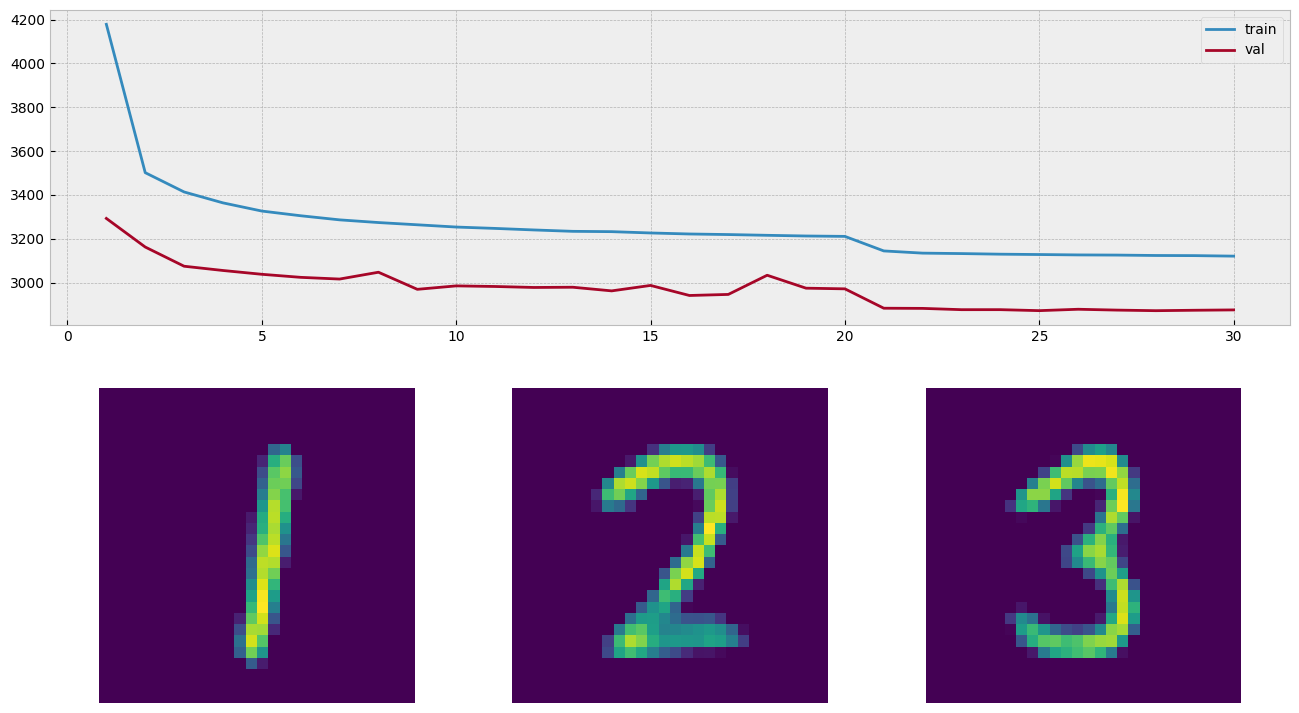

In [46]:
from IPython.display import clear_output
n_epochs = 30
train_losses = []
val_losses = []

for epoch in range(1, n_epochs + 1):
    autoencoder.train()
    train_losses_per_epoch = []
    for batch, y_batch in train_loader:
        labels = torch.nn.functional.one_hot(y_batch, num_classes=10)
        optimizer.zero_grad()
        mu, logsigma, reconstruction = autoencoder.forward(batch.to(device), labels.to(device))
        loss = criterion(batch.to(device), mu, logsigma, reconstruction)
        loss.backward()
        optimizer.step()
        train_losses_per_epoch.append(loss.item())

    train_losses.append(np.mean(train_losses_per_epoch))

    autoencoder.eval()
    val_losses_per_epoch = []
    with torch.no_grad():
        for batch, y_batch in test_loader:
            labels = torch.nn.functional.one_hot(y_batch, num_classes=10)
            mu, logsigma, reconstruction = autoencoder.forward(batch.to(device), labels.to(device))
            loss = criterion(batch.to(device), mu, logsigma, reconstruction)
            val_losses_per_epoch.append(loss.item())
        
    val_losses.append(np.mean(val_losses_per_epoch))
    scheduler.step()
    
    clear_output(True)
    
    print(f'epoch: {epoch} loss train: {np.mean(train_losses_per_epoch):.4f} loss val: {np.mean(val_losses_per_epoch):.4f}')
    val_data = reconstruction.to('cpu').view([-1, 28, 28])
    val_data[val_data<0] = 0
    plot_epoch(train_losses, val_losses, epoch, val_data)

### Sampling


Тут мы будем сэмплировать из CVAE. Это прикольнее, чем сэмплировать из простого AE/VAE: тут можно взять один и тот же латентный вектор и попросить CVAE восстановить из него картинки разных классов!
Для MNIST вы можете попросить CVAE восстановить из одного латентного вектора, например, картинки цифры 5 и 7.

In [47]:
#Создадим тензоры из 10 лейблов для тройки и семерки
three = torch.zeros([10, 10])
three[:,3] = 1
seven = torch.zeros([10, 10])
seven[:,7] = 1

In [48]:
#Создадим несколько случайных латентных векторов CVAE для тройки и семерки с одинаковым распределением в основе
seed = np.random.seed(7)
z = torch.FloatTensor(np.array([np.random.normal(0, 1, features) for i in range(10)])).to(device)
output_3 = autoencoder.decode(z, three.to(device)).detach().to('cpu').view([-1, 28, 28])
output_7 = autoencoder.decode(z, seven.to(device)).detach().to('cpu').view([-1, 28, 28])
output_3[output_3 < 0] = 0
output_3[output_3 > 1] = 1
output_7[output_7 < 0] = 0
output_7[output_7 > 1] = 1

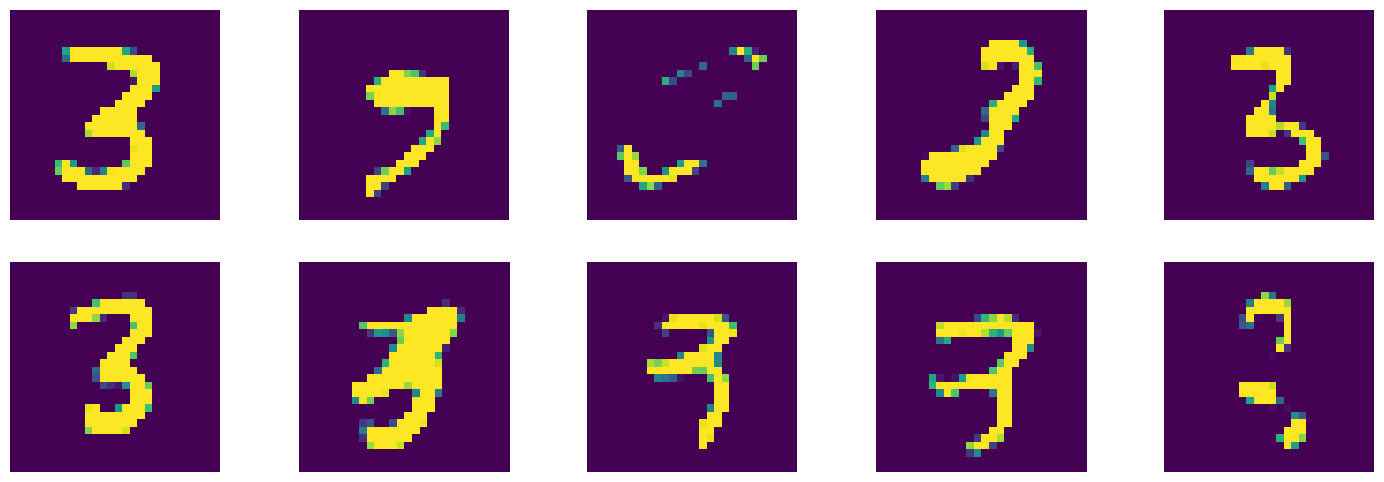

In [49]:
#Здесь наши тройки
plt.figure(figsize=(18, 6))
for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.axis("off")
    plt.imshow(output_3[i])
plt.show();

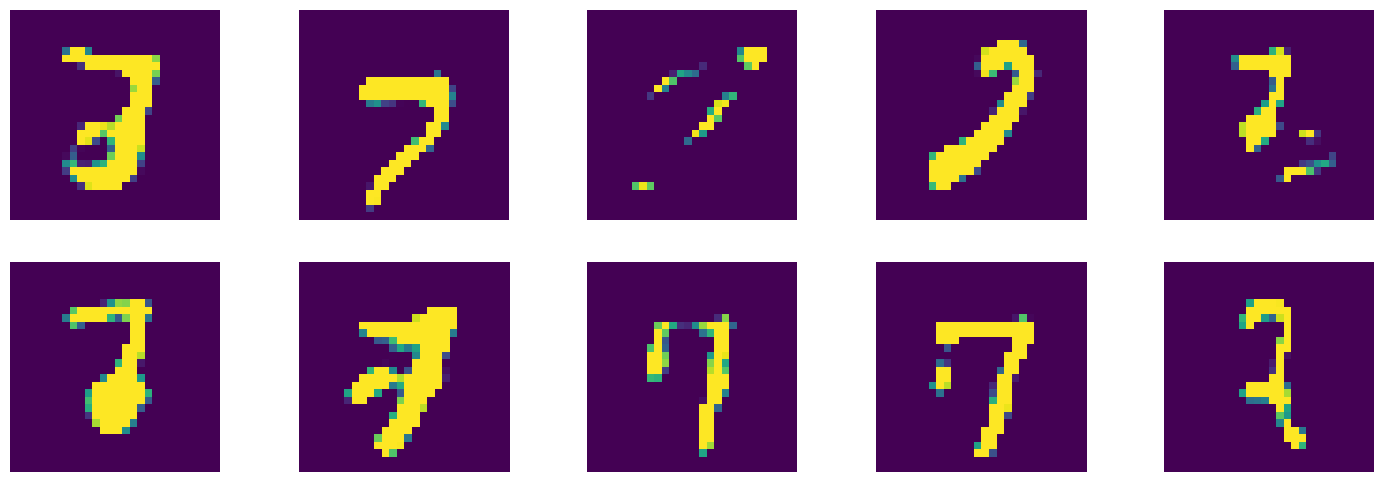

In [50]:
#А здесь семерки
plt.figure(figsize=(18, 6))
for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.axis("off")
    plt.imshow(output_7[i])
plt.show();

Splendid! Вы великолепны!


### Latent Representations

Давайте посмотрим, как выглядит латентное пространство картинок в CVAE и сравним с картинкой для VAE =)

Опять же, нужно покрасить точки в разные цвета в зависимости от класса.

In [51]:
#У меня конкатенация вшита в дектодер, поэтому для представления латентного пространстка сконкатенирую выход кодировщика с one-hot лейблом
mnist_coords = np.ones([1, features+10])
minst_labels = np.ones([1])
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        mu, _ = autoencoder.encode(X_batch.to(device))
        lab = torch.nn.functional.one_hot(y_batch, num_classes=10)
        concat = np.hstack([mu.to('cpu').numpy(), lab])
        mnist_coords = np.vstack([mnist_coords, concat])
        minst_labels =np.concatenate((minst_labels, y_batch.numpy()))
mnist_coords = mnist_coords[1:]
minst_labels = minst_labels[1:]

In [52]:
from sklearn.manifold import TSNE
coords_embedded = TSNE(n_components=2, learning_rate='auto', init='random', perplexity=30, random_state=42).fit_transform(mnist_coords)

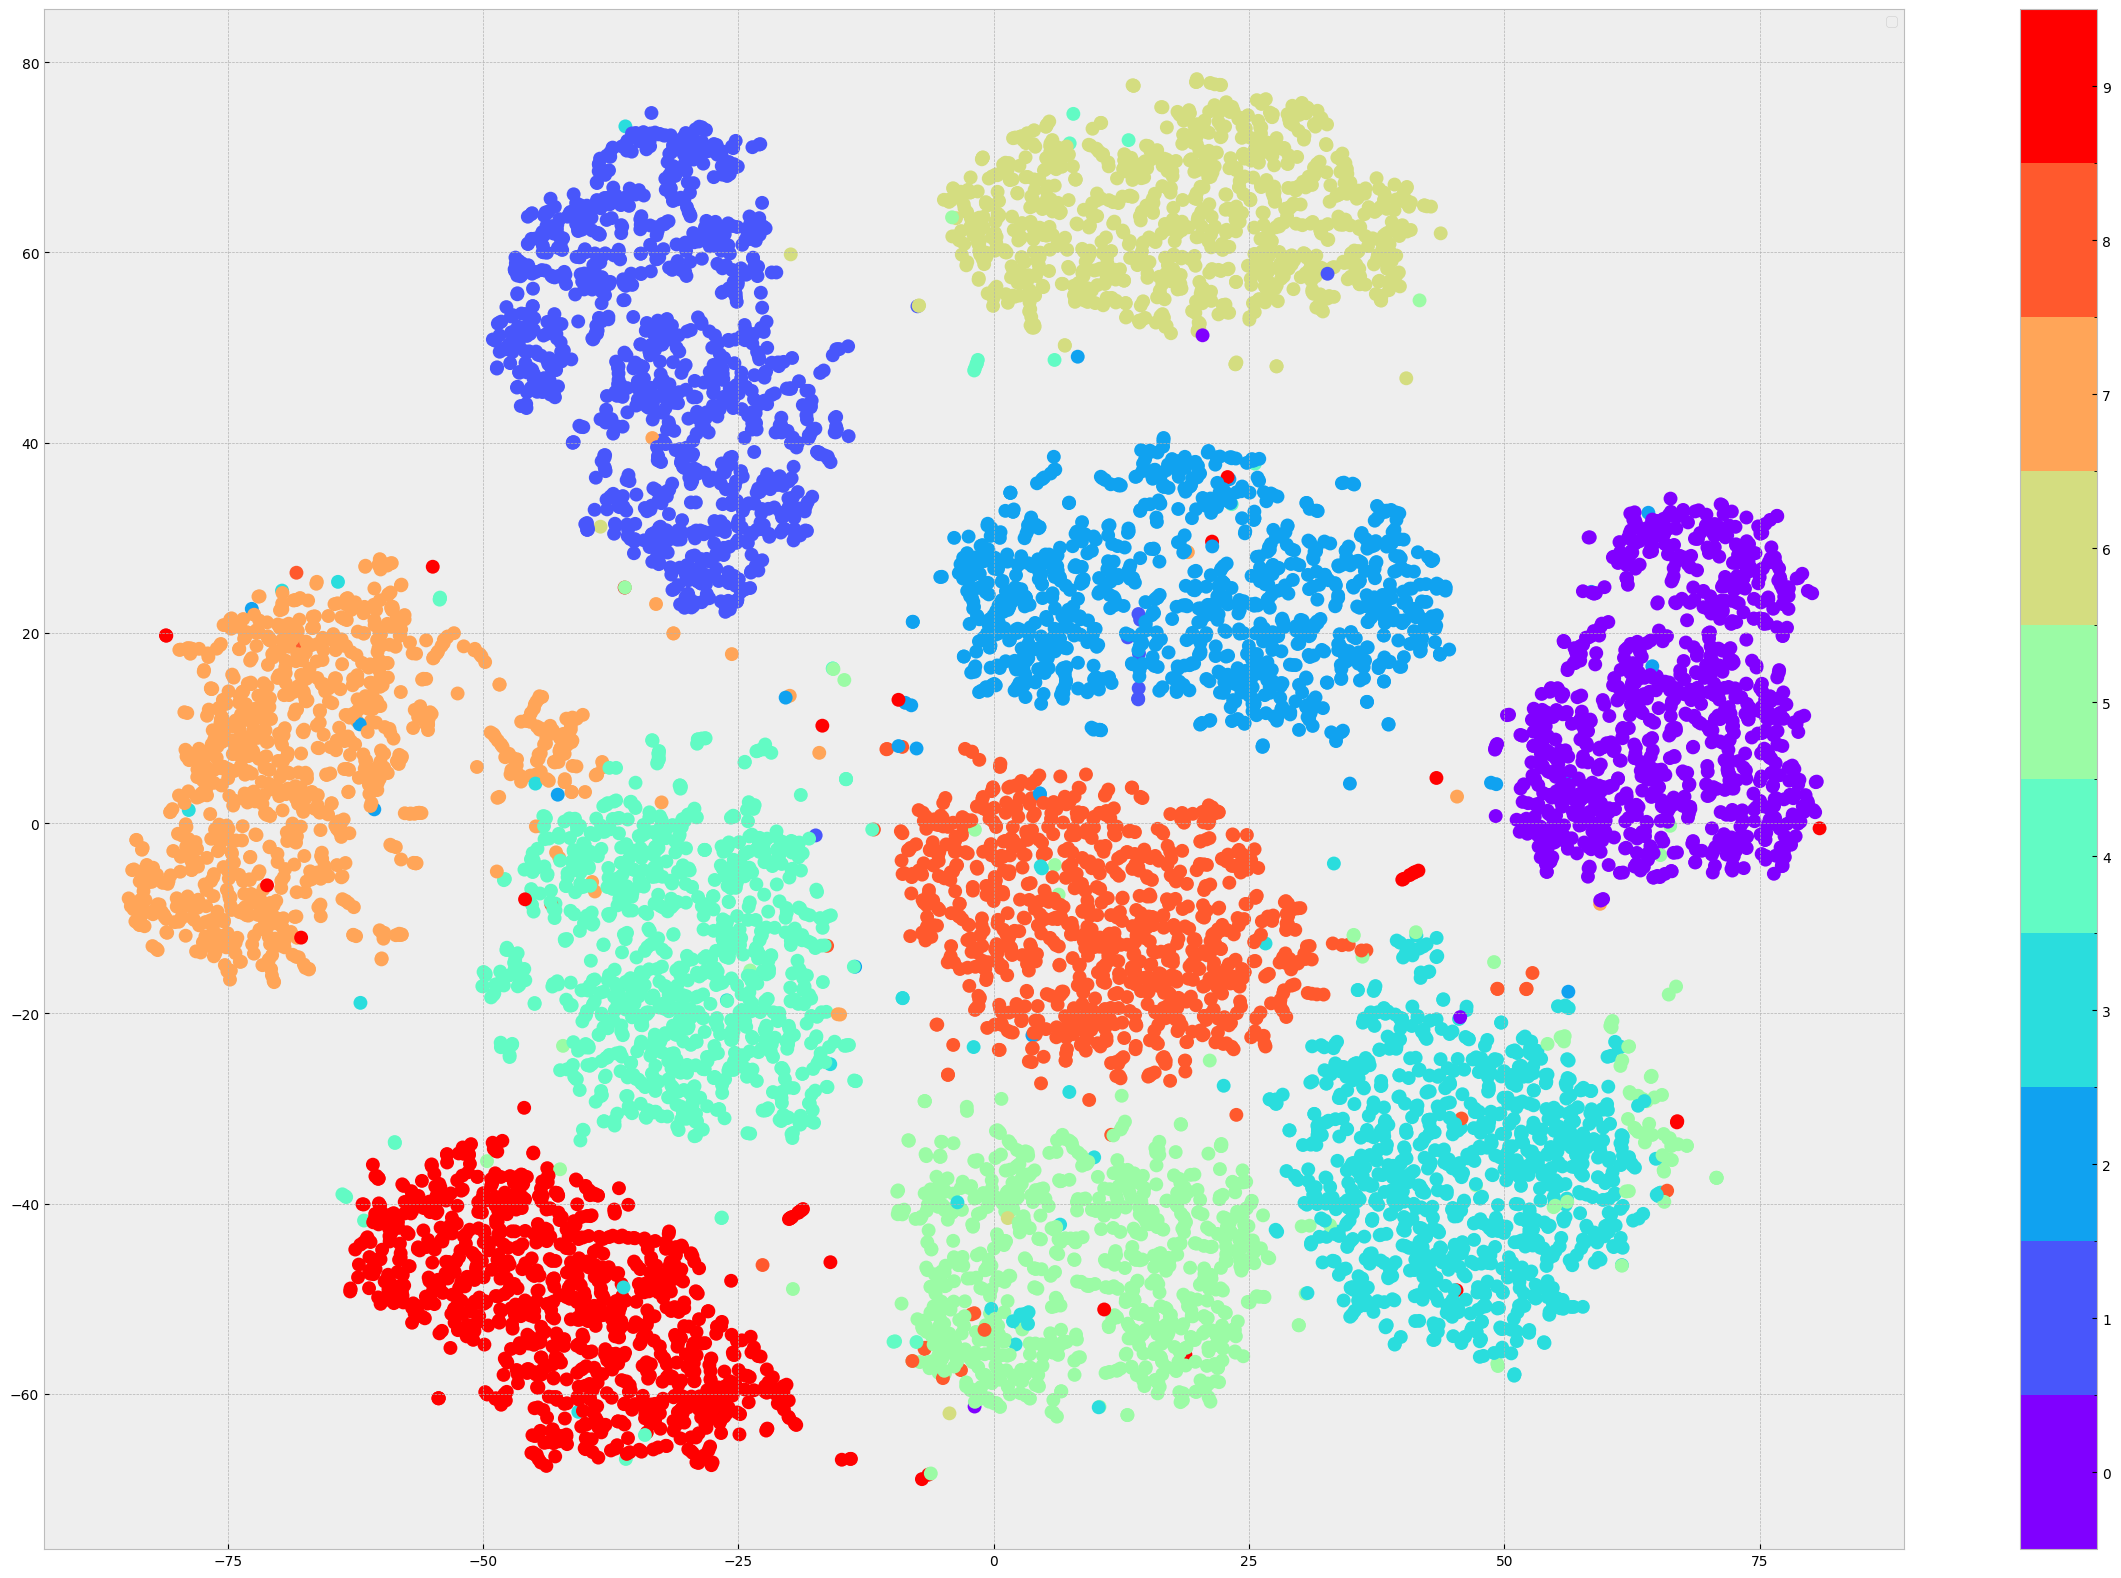

In [53]:
#Аналогичное распределение латентных векторов для CVAE
from matplotlib import colors
plt.figure(figsize=(30,20))
cmap = plt.cm.rainbow
norm = colors.BoundaryNorm(np.arange(-0.5, 10.5, 1), cmap.N)

plt.scatter(coords_embedded[:, 0], coords_embedded[:, 1], c=minst_labels, cmap=cmap, norm=norm, s=100, edgecolor='none')
plt.colorbar(ticks=np.arange(0, 10, 1))
plt.legend()
plt.show()

Что вы думаете насчет этой картинки? Отличается от картинки для VAE?

На данной картинке видно, что калссы цифр более четко отделены друг от друга, нежели в стандартном VAE.